In [3]:
import pandas as pd
import os
import yfinance
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

In [4]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [5]:
companies = pd.read_csv('data/companies/Stock_watchlist.csv')
price_history_df = pd.read_csv('data/notebook/price_drop_df.csv')

In [6]:
df = price_history_df

In [7]:
splitted = df['Date'].str.split('-', expand=True)

df['Month'] = splitted[1].astype('int')
df['Year'] = splitted[0].astype('int')
df['Quarter end'] = np.where(df['Month'] % 3 == 0, 1, 0)

In [8]:
date_counts = df['Date'].value_counts()
df['Amount of other stock dropping this date'] = df['Date'].map(date_counts)

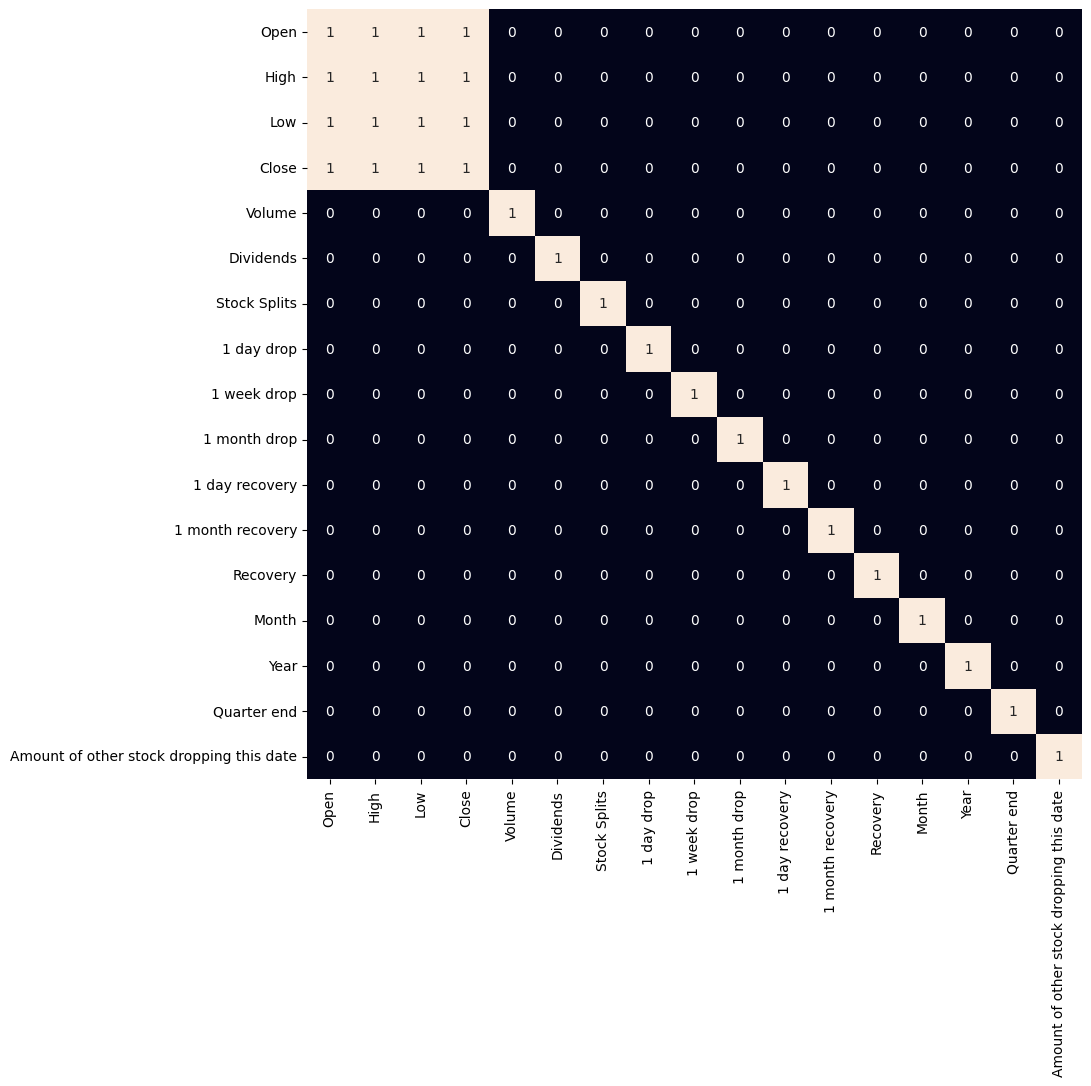

In [9]:
plt.figure(figsize=(10, 10))

# As our concern is with the highly
# correlated features only so, we will visualize
# our heatmap as per that criteria only.
sb.heatmap(df.drop(['Date', 'Symbol', 'Security', 'GICS Sector', 'GICS Sub-Industry', 'Headquarters Location', 'Date added', 'CIK', 'Founded'], axis=1).corr() > 0.9, annot=True, cbar=False)
plt.show()

In [10]:
features = df[['Amount of other stock dropping this date', 'Quarter end', 'Month', 'Year', '1 day recovery', '1 day drop' , '1 week drop', '1 month drop', 'Stock Splits', 'Dividends', 'Volume', 'Security', 'GICS Sector']]
target = df['Recovery']

features = df.drop(['Date', '1 month recovery', 'Recovery', 'Date added', 'Founded', 'Headquarters Location', "CIK", "Symbol"], axis=1)
target = df['Recovery']

In [11]:
target.value_counts()

Recovery
0    12694
1      920
Name: count, dtype: int64

In [12]:
recovered = df[df['Recovery'] == 1]

In [13]:
categorical_columns = features.select_dtypes(include=['object', 'category']).columns
numeric_columns = features.select_dtypes(include=['number']).columns

# Preprocessing for categorical data: impute missing with a constant then one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # fill NaNs with 'missing'
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Preprocessing for numeric data: impute missing with median
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns)
    ]
)

# Create the final pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

In [14]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Fit the model
rf_pipeline.fit(X_train, y_train)

# Optional: evaluate
accuracy = rf_pipeline.score(X_test, y_test)
print(f"Model Accuracy: {accuracy:.2f}")

Model Accuracy: 0.96


In [15]:
rf = rf_pipeline.named_steps['classifier']

# Get the preprocessor step
preprocessor = rf_pipeline.named_steps['preprocessor']

# Get feature names after preprocessing
# For numeric columns, the names stay the same
numeric_cols = list(preprocessor.transformers_[0][2])

# For categorical columns, get one-hot encoded feature names
# The OneHotEncoder is the second transformer in the ColumnTransformer
ohe = preprocessor.transformers_[1][1].named_steps['onehot']
cat_cols = list(preprocessor.transformers_[1][2])

# Get the one-hot encoded column names
ohe_feature_names = ohe.get_feature_names_out(cat_cols)

# Combine all feature names
all_feature_names = numeric_cols + list(ohe_feature_names)

# Get feature importances from the model
importances = rf.feature_importances_

# Create a dataframe for easy viewing
feature_importances = pd.DataFrame({
    'feature': all_feature_names,
    'importance': importances
})

# Sort by importance descending
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

In [16]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay

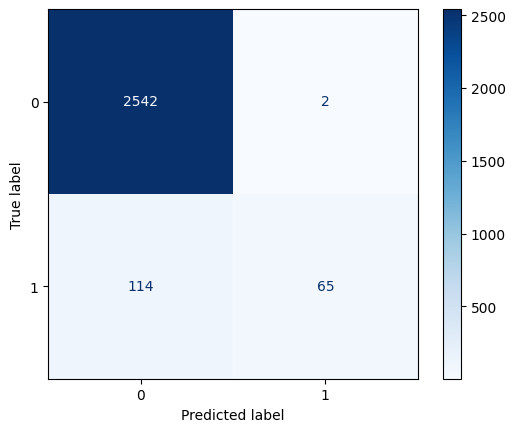

In [17]:
y_pred = rf_pipeline.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Customize the display with a colormap
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

In [18]:
rf_pipeline.predict

<bound method Pipeline.predict of Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits',
       '1 day drop', '1 week drop', '1 month drop', '1 day recovery', 'Month',
       'Year', 'Quarter end', 'Amount of other stock dropping this date'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                              

In [19]:
error error error

SyntaxError: invalid syntax (1874145827.py, line 1)

In [18]:
from sklearn.tree import export_graphviz
import graphviz

tree_vis = export_graphviz(rf.estimators_[0],
                feature_names=all_feature_names,
                filled=True,
                rounded=True)
graph = graphviz.Source(tree_vis)
graph.render("tree_visualization.pdf")

'tree_visualization.pdf'